# Function approximation using RNNs

### Libraries

In [31]:
import matplotlib.pyplot as plt
import torch 
import torch.quantization
import numpy as np
from sklearn.metrics import mean_squared_error
from training import *
from recurrent import *
from functions import *

## Function 3 Approximation

LSTM, Many-to-one approach.

#### loading the data 

In [16]:
Input_train_3, f3_train, Input_test_3, f3_test, Input_data_3, f3_data =data_splitter(3) 



In [17]:
lr=10**(-2)
epochs = 5000
alpha=10**(-1)



#### Training 

In [18]:
torch.manual_seed(34)
loss_array_f3,model_f3= recurrent_model_training_3(epochs, 3, lr, RNN_f3(), alpha)

100%|██████████| 5000/5000 [00:25<00:00, 194.47it/s]


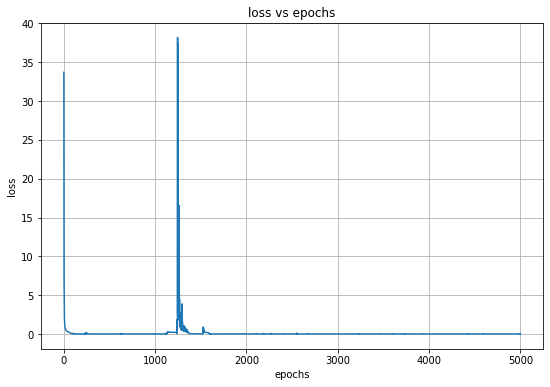

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=[9,6])
plt.plot(range(len(loss_array_f3)), loss_array_f3)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.grid()
plt.savefig('./figures/loss_vs_epochs_f3')
plt.show()


Log-scale visualization

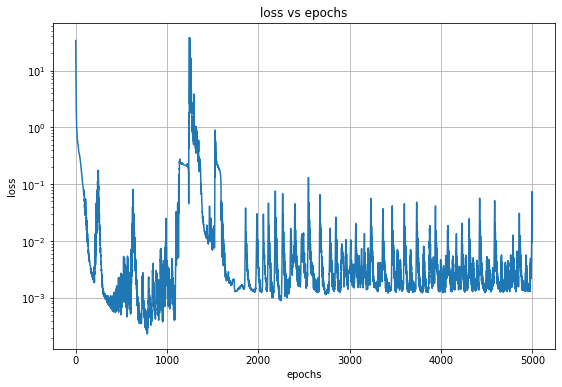

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=[9,6])
plt.plot(range(len(loss_array_f3)), loss_array_f3)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.title('loss vs epochs')
plt.grid()
plt.savefig('./figures/loss_vs_epochs_f3')
plt.show()


Loss MSE

In [21]:
MSE_3=min(loss_array_f3)
print(MSE_3)

0.00023283108021132648


#### Visualizing the training 

Getting the approximation

In [22]:
with torch.no_grad():
    Input_tr=Input_train_3.reshape(-1, 25, 1)
   

    f3_approx_train=model_f3.forward(Input_tr)


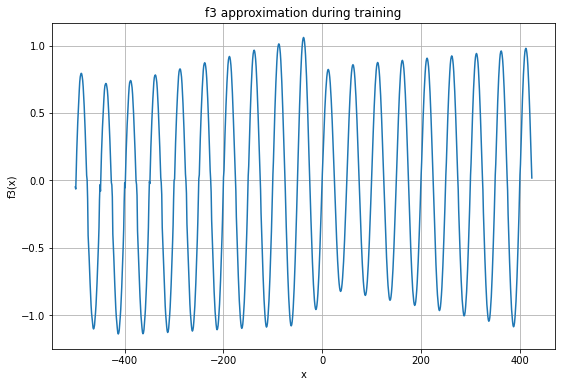

In [23]:
Input_train=Input_train_3.reshape(len(Input_train_3),-1).numpy()
f3_approx_train=np.array(f3_approx_train.reshape(len(Input_train_3),-1))
plt.figure(figsize=[9,6])
plt.plot(Input_train, f3_approx_train)
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.title('f3 approximation during training')
plt.grid()
plt.savefig('./figures/f3_approximation_train')
plt.show()

#### Generalization capacity

Getting the approximation

In [24]:
with torch.no_grad():
    Input_test=Input_test_3.reshape(-1, 25, 1)
   

    f3_approx_test=model_f3.forward(Input_test)

Visualization

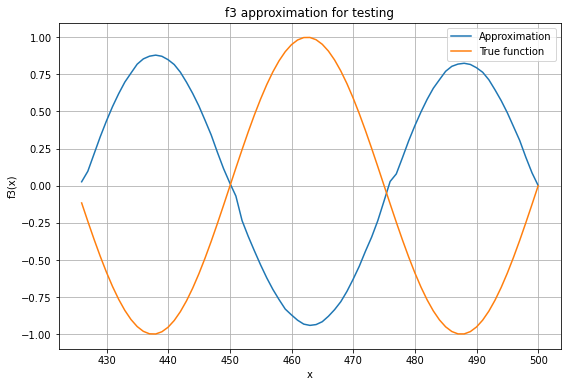

In [25]:
Input_test_3=Input_test_3.flatten()
f3_approx_test=np.array(f3_approx_test).flatten()
f3_test=np.array(f3_test).flatten()
plt.figure(figsize=[9,6])
plt.plot(Input_test_3, f3_approx_test, label='Approximation')
plt.plot(Input_test_3, f3_test, label='True function ')
plt.legend()
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.title('f3 approximation for testing')
plt.grid()
plt.savefig('./figures/f3_approximation_test')
plt.show()

#### Final function 

In [26]:
with torch.no_grad():
    Input_data=Input_data_3.reshape(-1, 25, 1)
   

    f3_approx=model_f3.forward(Input_data)
f3_approx.size()

torch.Size([40, 25])

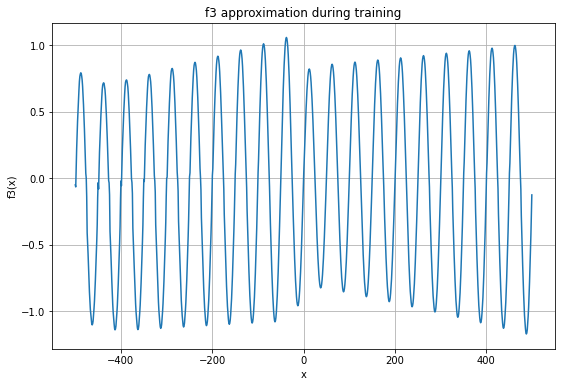

In [27]:
Input_data_array=Input_data.flatten()
f3_approx=np.array(f3_approx).flatten()
plt.figure(figsize=[9,6])
plt.plot(Input_data_array, f3_approx)
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.title('f3 approximation during training')
plt.grid()
plt.savefig('./figures/f3_approximation')
plt.show()

Zoom on the testing part

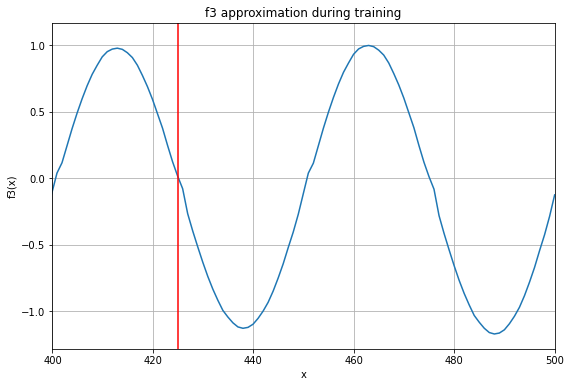

In [28]:
Input_data_array=Input_data.flatten()
f3_approx=np.array(f3_approx).flatten()
plt.figure(figsize=[9,6])
plt.plot(Input_data_array, f3_approx)
plt.xlim(400, 500)
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.title('f3 approximation during training')
plt.axvline(425, color = 'r', linestyle = '-')
plt.grid()
plt.show()

perfectly smooth ?!

#### Quantizing the model

In [29]:
torch.backends.quantized.engine = 'qnnpack'
NN3_to_be_quantized=model_f3
model_int8_f3 = torch.quantization.quantize_dynamic(
    model_f3,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

[W TensorImpl.h:1408] Warning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (function operator())


Effect of quantization on the MSE

Accuracy of the model 

In [34]:
TE_f3=mean_squared_error(np.array(f3_approx_test), np.array(f3_test))
print('Non Quantized model performance : ', TE_f3)


Non Quantized model performance :  1.756554


In [43]:
with torch.no_grad():
    Input_test_quant=Input_test_3.reshape(-1, 25, 1)

    f3_approx_test_quant=model_int8_f3.forward(Input_test_quant)
f3_approx_test_quant.size()

torch.Size([3, 25])

Accuracy of the quantized model 

In [44]:
TE_f3_Quant=mean_squared_error(np.array(f3_approx_test_quant.flatten()), np.array(f3_test))
print('Quantized model performance : ', TE_f3_Quant)
print('Non Quantized model performance : ',TE_f3)

Quantized model performance :  1.767847
Non Quantized model performance :  1.756554


Performance loss

In [45]:
print(f'Performance reduction : {np.ceil(100*(TE_f3_Quant-TE_f3)/TE_f3)} %')

Performance reduction : 1.0 %
